# Bayesian Data Analysis of House Prices

We apply Bayesian model selection and hierarchical regression model to estimate house prices. Model selection is performed on numerical variables, and hierarchy is set by house location ("Neighborhood").

# Package

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statistics
import math
import random

from numpy.linalg import inv
from scipy.linalg import cholesky
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

# Training data

In [127]:
train = pd.read_csv("train.csv")
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [128]:
train.shape

(1460, 81)

# Missing data

In [129]:
total = train.isnull().sum().sort_values(ascending = False)
percent = (train.isnull().sum() / train.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], 
                         axis = 1, 
                         keys = ['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [130]:
COLUMNS_drop = (missing_data[missing_data['Total'] > 1]).index
train = train.drop(labels = COLUMNS_drop, axis = 1)
train.shape

(1460, 63)

In [131]:
INDEX_drop = train.loc[train['Electrical'].isnull()].index
train = train.drop(labels = INDEX_drop, axis = 0)
train.shape

(1459, 63)

In [132]:
COLUMNS = train.columns
COLUMNS_res = ""
COLUMNS_num = train._get_numeric_data().columns
COLUMNS_cat = list(set(COLUMNS) - set(COLUMNS_num))
print('Number of numeric columns: {}'.format(len(COLUMNS_num)))
print('Number of categorical columns: {}'.format(len(COLUMNS_cat)))

Number of numeric columns: 35
Number of categorical columns: 28


One of the numeric column is our response "SalePrice". We put all the numeric variables into variable selection process. We consider only numeric variables in the selection.

In [133]:
train = train[COLUMNS_num]
train.shape

(1459, 35)

# Drop highly correlated variable

We remove one of variables which has high correlation. It enables to solve inverse matrix calculation and prevents multicolinearity.

In [134]:
corrmat = train.corr()
corrmat = corrmat.rename_axis(None).rename_axis(None, axis = 1)
corrmat = corrmat.stack().reset_index()
corrmat.columns = ['var_1', 'var_2', 'correlation']
corrmat = corrmat[corrmat['correlation'] != 1]
corrmat.sort_values(by = 'correlation', ascending = False).head(15)

,var_1,var_2,correlation
863,GarageArea,GarageCars,0.882613
829,GarageCars,GarageArea,0.882613
511,GrLivArea,TotRmsAbvGrd,0.825576
749,TotRmsAbvGrd,GrLivArea,0.825576
395,1stFlrSF,TotalBsmtSF,0.819393
361,TotalBsmtSF,1stFlrSF,0.819393
1193,SalePrice,OverallQual,0.791069
139,OverallQual,SalePrice,0.791069
524,GrLivArea,SalePrice,0.708618
1204,SalePrice,GrLivArea,0.708618


In [135]:
COLUMNS_drop = ['GarageArea', 'TotRmsAbvGrd', 'TotalBsmtSF', '2ndFlrSF']
train = train.drop(labels = COLUMNS_drop, axis = 1)
train.shape

(1459, 31)

# Data for Bayesian model selection

In [136]:
X = train.iloc[:, 1:(train.shape[1]-1)].values
y = train.iloc[:, train.shape[1]-1].values

# Function for Bayesian model selection

In [137]:
def lpy_X(y, X, g = len(y), nu0 = 1):
    
    n = X.shape[0]
    p = X.shape[1]
    s20 = sum(sm.OLS(y, X).fit().resid**2) / sm.OLS(y, X).fit().df_resid
    
    if p == 0:
        Hg = 0
        s20 = statistics.mean(y**2)
    
    elif p > 0:
        X_T = np.transpose(X)
        Hg = (g/(g+1)) * np.dot(np.dot(X, inv(np.dot(X_T, X))), X_T)
        
    y_T = np.transpose(y)
    identity_mat = np.diag(np.repeat(1, n))
    i_H = identity_mat - Hg
    SSRg = np.dot(np.dot(y_T, i_H), y)
    
    return (-0.5
            * (n * np.log(np.pi) + p * np.log(1+g) + (nu0+n)*np.log(nu0*s20+SSRg) - nu0*np.log(nu0*s20))
            + math.lgamma((nu0+n)/2)
            + math.lgamma(nu0/2))

# MCMC setup

In [138]:
z = np.repeat(1, X.shape[1])
lpy_c = lpy_X(y = y, X = X[:, z == 1])
S = 100
Z = np.zeros([S, X.shape[1]], dtype = int)

# Gibbs sampler

In [139]:
for s in np.arange(0, S, 1):
        
    for j in pd.Series(np.arange(0,29,1)).sample(29, replace = False).values:
        
        zp = z.copy()
        zp[j] = 1 - zp[j]
        lpy_p = lpy_X(y, X[:, zp == 1])
        r = (lpy_p - lpy_c)*(-1)**(zp[j] == 0)
        z[j] = np.random.binomial(n=1, p=(1/(1+np.exp(-r))), size=1)
        
        if z[j] == zp[j]:
            lpy_c = lpy_p
    
    Z[s,:] = z  
    
    # Display sampling process by printing a single dot for each step
    print('.', end = '')
    
    if s == (S-1):
        print('Done!')

....................................................................................................Done!


In [142]:
ps = pd.Series([tuple(i) for i in Z])
counts = ps.value_counts(normalize = True)
counts[0:5]

(1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1)    0.10
(1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1)    0.07
(1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1)    0.06
(1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1)    0.05
(1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1)    0.03
dtype: float64

In [143]:
COLUMNS = np.array(train.columns)
COLUMNS = np.delete(COLUMNS, [0, 30])
COLUMNS = COLUMNS[np.array(counts.index[0]) == 1]
COLUMNS

array(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'BsmtFinSF1', 'BsmtUnfSF', 'GrLivArea', 'BsmtFullBath',
       'BedroomAbvGr', 'GarageCars', 'WoodDeckSF', 'ScreenPorch',
       'YrSold'], dtype=object)

In [17]:
train = pd.concat([train[['Id', 'SalePrice']], train[COLUMNS]], axis = 1)
train.head()

,Id,SalePrice,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,BsmtFinSF1,BsmtUnfSF,GrLivArea,BsmtFullBath,BedroomAbvGr,GarageCars,WoodDeckSF,ScreenPorch,YrSold
0,1,208500,60,8450,7,5,2003,706,150,1710,1,3,2,0,0,2008
1,2,181500,20,9600,6,8,1976,978,284,1262,0,3,2,298,0,2007
2,3,223500,60,11250,7,5,2001,486,434,1786,1,3,2,0,0,2008
3,4,140000,70,9550,7,5,1915,216,540,1717,1,3,3,0,0,2006
4,5,250000,60,14260,8,5,2000,655,490,2198,1,4,3,192,0,2008


# Data for hierarchical regression model

In [18]:
neighbor = pd.read_csv('train.csv')[['Id', 'Neighborhood']]
train = pd.merge(left = train, right = neighbor, left_on = 'Id', right_on = 'Id', how = 'left')
print(train.shape)

(1459, 17)


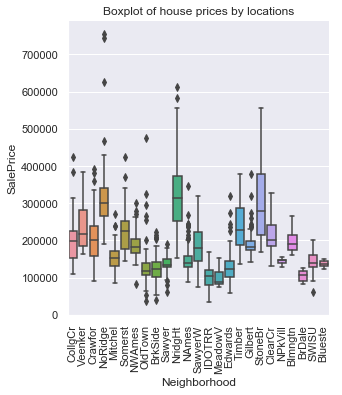

In [40]:
_ = sns.catplot(x = 'Neighborhood', y = 'SalePrice', kind = 'box', data = train)
_ = plt.xticks(rotation = 90)
_ = plt.title('Boxplot of house prices by locations')
plt.show()

In [20]:
X_COLUMNS = COLUMNS

# preprocessing scale function shows warning if data type is int64
temp_df = train[X_COLUMNS].astype(np.float64)

Neighborhood_list = np.unique(train['Neighborhood'])
m = len(Neighborhood_list)
X_list = []

for i in np.arange(0,m,1):
    temp = temp_df.loc[train['Neighborhood'] == Neighborhood_list[i]]
    # centering, not scaling
    temp = preprocessing.scale(temp.values,
                               with_mean = True,
                               with_std = False)
    # adding intercept. do this after centering, otherwise intercept will be 0
    temp = sm.add_constant(temp)
    X_list.append(temp)
    
X = X_list

In [21]:
temp_df = train['SalePrice']
y_list = []

for i in np.arange(0, len(Neighborhood_list),1):
    y_list.append(temp_df.loc[train['Neighborhood'] == Neighborhood_list[i]])
    
y = y_list

# Functions for Markov chain Monte Carlo (MCMC)

In [22]:
def rmvnorm(n, mu, Sigma):
    E = np.random.normal(0, 1, n*len(mu))
    return np.dot(E, cholesky(Sigma, lower = False)) + mu

In [23]:
def rwish(nu0, S0):
    sS0 = cholesky(S0, lower = False)
    Z = np.dot(np.random.normal(0, 1, rwish_mean*rwish_var.shape[0]).reshape(rwish_mean, rwish_var.shape[0]), sS0)
    S = np.dot(np.transpose(Z), Z)
    return S

# Prior values

In [24]:
m = len(Neighborhood_list)
p = X[0].shape[1]
BETA_LS = np.zeros([m, p])
S2_LS = np.zeros(m)

for i in np.arange(0,m,1):
    
    # fit OLS to each group
    results = sm.OLS(y[i], X[i]).fit()
    
    # calculate parameters
    beta = results.params
    
    # calculate sample variance
    RSS = sum(results.resid ** 2)
    df = results.df_resid
    sample_variance = RSS/df
    
    # store outputs
    BETA_LS[i] = beta
    S2_LS[i] = sample_variance  

C:\Users\yukic\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


In [25]:
p = X[0].shape[1]
theta = pd.DataFrame(BETA_LS).apply(statistics.mean, axis = 0)
mu0 = pd.DataFrame(BETA_LS).apply(statistics.mean, axis = 0)
nu0 = 1
s2 = statistics.mean(S2_LS[np.isfinite(S2_LS)])
s20 = statistics.mean(S2_LS[np.isfinite(S2_LS)])
eta0 = p + 2
Sigma = np.cov(BETA_LS, rowvar = False)
S0 = np.cov(BETA_LS, rowvar = False)
L0 = np.cov(BETA_LS, rowvar = False)
BETA = BETA_LS
iL0 = inv(L0)
iSigma = inv(Sigma)

N = np.zeros(m)
for i in np.arange(0,m,1):
    N[i] = len(X[i])

In [26]:
# MCMC setting and storing
random.seed(0)
S = 5000
S2_b = np.zeros(S)
THETA_b = np.zeros([S, p])
Sigma_ps = np.zeros([p, p])
BETA_ps = BETA * 0
SIGMA_PS = np.zeros([S, p * p])
BETA_pp = np.zeros([S, p])

# Likelihood and Posterior values (MCMC part)

In [27]:
for s in np.arange(0,S,1):

    # update beta_j
    for j in np.arange(0,m,1):
        Vj = inv(iSigma + np.dot(np.transpose(X[j]), X[j])/s2)
        Ej = np.dot(Vj, np.dot(iSigma, theta) + np.dot(np.transpose(X[j]), y[j])/s2)
        BETA[j] = rmvnorm(1, Ej, Vj)

    # update theta
    Lm = inv(iL0 + m * iSigma)
    mum = np.dot(Lm, np.dot(iL0, mu0) + np.dot(iSigma, pd.DataFrame(BETA).apply(sum, axis = 0)))
    theta = rmvnorm(1, mum, Lm)

    # update Sigma
    rwish_mean = eta0 + m
    rwish_var = inv(S0 + np.dot(np.transpose(BETA - theta), BETA - theta))
    iSigma = rwish(rwish_mean, rwish_var)

    # update s2
    RSS = 0
    for j in np.arange(0,m,1):
        RSS = RSS + sum((y[j] - np.dot(X[j], BETA[j])) ** 2)
    s2 = 1/np.random.gamma(shape = (nu0 + sum(N))/2, scale = 1/((nu0*s20+RSS)/2), size = 1)

    # store results
    S2_b[s] = s2
    THETA_b[s] = theta
    Sigma_ps = Sigma_ps + inv(iSigma)
    BETA_ps = BETA_ps + BETA
    SIGMA_PS[s] = np.matrix.flatten(inv(iSigma))
    BETA_pp[s] = rmvnorm(1, theta, inv(iSigma))
    
    # Display sampling process by printing a single dot
    if (s % 100 == 0):
        print('.', end = '')
        
    if s == (S-1):
        print('Done!')

..................................................Done!


# Parameters estimated MCMC

The following is the estimated predictors' coefficient by MCMC.

In [28]:
neighborhood_list_df = pd.DataFrame(Neighborhood_list,
                                    columns = ['Neighborhood'])
coef = pd.DataFrame(BETA_ps/S)
coef = pd.concat([neighborhood_list_df, coef], 
                 axis = 1)

# Rename columns
COLUMNS_coef = COLUMNS.copy()
COLUMNS_coef = COLUMNS_coef + '_coef'
COLUMNS_coef = np.append(['Neighborhood', 'Intercept_coef'], COLUMNS_coef)
coef.columns = COLUMNS_coef

coef

,Neighborhood,Intercept_coef,MSSubClass_coef,LotArea_coef,OverallQual_coef,OverallCond_coef,YearBuilt_coef,BsmtFinSF1_coef,BsmtUnfSF_coef,GrLivArea_coef,BsmtFullBath_coef,BedroomAbvGr_coef,GarageCars_coef,WoodDeckSF_coef,ScreenPorch_coef,YrSold_coef
0,Blmngtn,194718.968895,-66.165203,0.419352,10109.591828,8805.897509,295.660413,6.262771,-2.264980,71.113777,9181.919681,-6471.607491,5358.676696,45.788120,66.389335,-1565.517756
1,Blueste,139795.220707,-77.701621,0.654662,8241.819031,7280.679310,-3.579103,10.927907,2.266792,39.610059,6793.855767,518.180828,8840.773322,32.174213,82.778461,-77.856195
2,BrDale,105244.090174,-45.150565,0.934756,6912.034515,6655.254783,-414.270460,9.711293,3.101112,20.227015,6095.019250,4809.168260,10404.247930,28.091268,96.924560,442.134908
3,BrkSide,125371.323607,-15.767190,3.815140,7462.724882,5998.178393,299.834507,22.821864,15.226844,31.566109,5673.631813,1315.376124,7931.387765,5.788823,96.506145,572.230730
4,ClearCr,211667.323723,-230.939010,0.478731,14185.447244,5540.809814,191.387186,19.252681,5.076952,59.718875,9989.583332,-4511.892149,14506.553739,31.958571,-20.318506,462.379734
5,CollgCr,197812.993453,-123.588262,1.220868,11469.903824,8200.284168,555.750618,29.535785,12.468169,67.452679,8698.526236,-3402.766692,11597.127422,25.496275,78.899456,667.194249
6,Crawfor,210508.488463,-178.285212,-0.711902,17022.418358,10482.884049,493.151704,38.625379,16.015575,77.325083,1683.076663,-15808.875755,483.199525,1.099769,-35.972256,-1722.285250
7,Edwards,127840.419243,-120.603943,-1.562448,4416.759359,7340.277065,370.240203,-4.561186,-5.585598,24.789739,11513.481663,10381.815200,13961.114334,60.958888,135.462466,330.567533
8,Gilbert,193049.584235,-191.118317,2.017286,13353.384094,7118.146883,709.801944,38.935914,26.526166,62.206844,7743.435287,-7397.474159,9872.125552,6.712643,28.148307,309.293607
9,IDOTRR,101234.140137,-61.270588,1.434410,7342.486350,8365.675393,259.475737,26.354644,21.278436,24.361587,4045.369550,2733.807681,5917.143324,15.007563,125.746701,-10.180462


# Training accuracy

In [98]:
temp_y = np.matrix(y[0]).transpose()
temp_x = np.matrix(X[0])
temp_yx = pd.DataFrame(np.concatenate((temp_y, temp_x), axis = 1))
temp_yx['Neighborhood'] = Neighborhood_list[0]

m = len(Neighborhood_list)

for i in range(1, m):
    temp_y = np.matrix(y[i]).transpose()
    temp_x = np.matrix(X[i])
    temp = pd.DataFrame(np.concatenate((temp_y, temp_x), axis = 1))
    temp['Neighborhood'] = Neighborhood_list[i]
    temp_yx = pd.concat([temp_yx, temp], axis = 0)
    
# Rename columns
COLUMNS_pred = COLUMNS.copy()
COLUMNS_pred = np.append(['SalePrice', 'Intercept'], COLUMNS_pred)
COLUMNS_pred = np.append(COLUMNS_pred, 'Neighborhood')
temp_yx.columns = COLUMNS_pred
    
train_pred_df = temp_yx.merge(coef, on = 'Neighborhood', how = 'left')

In [99]:
train_pred_df.head()

,SalePrice,Intercept,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,BsmtFinSF1,BsmtUnfSF,GrLivArea,...,YearBuilt_coef,BsmtFinSF1_coef,BsmtUnfSF_coef,GrLivArea_coef,BsmtFullBath_coef,BedroomAbvGr_coef,GarageCars_coef,WoodDeckSF_coef,ScreenPorch_coef,YrSold_coef
0,167240.0,1.0,5.882353,-388.176471,-0.176471,0.0,-0.235294,-180.0,103.588235,-179.941176,...,295.660413,6.262771,-2.26498,71.113777,9181.919681,-6471.607491,5358.676696,45.78812,66.389335,-1565.517756
1,192500.0,1.0,5.882353,-216.176471,-0.176471,0.0,-0.235294,-180.0,228.588235,127.058824,...,295.660413,6.262771,-2.26498,71.113777,9181.919681,-6471.607491,5358.676696,45.78812,66.389335,-1565.517756
2,192000.0,1.0,5.882353,-216.176471,0.823529,0.0,-1.235294,-172.0,103.588235,-158.941176,...,295.660413,6.262771,-2.26498,71.113777,9181.919681,-6471.607491,5358.676696,45.78812,66.389335,-1565.517756
3,172500.0,1.0,5.882353,523.823529,-0.176471,0.0,0.764706,-196.0,129.588235,-169.941176,...,295.660413,6.262771,-2.26498,71.113777,9181.919681,-6471.607491,5358.676696,45.78812,66.389335,-1565.517756
4,178740.0,1.0,5.882353,-326.176471,-0.176471,0.0,-1.235294,-196.0,246.588235,-13.941176,...,295.660413,6.262771,-2.26498,71.113777,9181.919681,-6471.607491,5358.676696,45.78812,66.389335,-1565.517756


In [100]:
# the 2nd argument of np.delete specifies the element position in array that you wan to drop.
COLUMNS_pred = np.delete(COLUMNS_pred, 0)
COLUMNS_pred = np.delete(COLUMNS_pred, len(COLUMNS_pred)-1)
train_pred_df['SalePrice_pred'] = 0

for i in range(len(COLUMNS_pred)):
    coefs = COLUMNS_pred[i] + '_coef'
    train_pred_df['SalePrice_pred'] = train_pred_df['SalePrice_pred'] + train_pred_df[coefs] * train_pred_df[COLUMNS_pred[i]]

In [101]:
np.round(train_pred_df[['SalePrice', 'SalePrice_pred']].head(), decimals = 0)

,SalePrice,SalePrice_pred
0,167240.0,173982.0
1,192500.0,192509.0
2,192000.0,190450.0
3,172500.0,180654.0
4,178740.0,186742.0


# Training accuracy

In [102]:
MSPE_train_BDA = statistics.mean((train_pred_df['SalePrice'] - train_pred_df['SalePrice_pred'])**2)
print('MSPE in training data by Bayesian model selection and hierarchical regression: {:,}'.format(round(MSPE_train_BDA)))

MSPE in training data by Bayesian model selection and hierarchical regression: 390,375,870


# Prediction in test data

In [103]:
test = pd.read_csv("test.csv")
test.shape

(1459, 80)

# Imputation missing values in test data

In [104]:
COLUMNS_pred = np.delete(COLUMNS_pred, 0)
COLUMNS_pred = np.append(['Id', 'Neighborhood'], COLUMNS_pred)
X_test = test[COLUMNS_pred]
print(X_test.shape)
print(X_test.isnull().sum())

(1459, 16)
Id              0
Neighborhood    0
MSSubClass      0
LotArea         0
OverallQual     0
OverallCond     0
YearBuilt       0
BsmtFinSF1      1
BsmtUnfSF       1
GrLivArea       0
BsmtFullBath    2
BedroomAbvGr    0
GarageCars      1
WoodDeckSF      0
ScreenPorch     0
YrSold          0
dtype: int64


In [105]:
# imputing missing values
COLUMNS_missing = COLUMNS_pred[X_test.isnull().sum() > 0]
test_temp = test[COLUMNS_missing]
imp_mean = SimpleImputer(missing_values = np.nan, strategy = 'mean')
test_temp = imp_mean.fit_transform(test_temp)
test_temp = pd.DataFrame(test_temp, columns = COLUMNS_missing)
print(test_temp.shape)
print(test_temp.isnull().sum())

(1459, 4)
BsmtFinSF1      0
BsmtUnfSF       0
BsmtFullBath    0
GarageCars      0
dtype: int64


In [106]:
COLUMNS_nonmiss = COLUMNS_pred[X_test.isnull().sum() == 0]
X_test = X_test[COLUMNS_nonmiss]
X_test = pd.concat([X_test, test_temp], axis = 1)

When we built train dataset for MCMC, we scaled predictors, ie deducted predictor values by means of each predictor. So we need to deduct test predictor values also.

In [108]:
train = pd.read_csv("train.csv")

for col in COLUMNS:
    
    mean = train.groupby('Neighborhood')[col].mean()
    mean_df = pd.DataFrame(data = {'Neighborhood':mean.index, 'mean':mean.values})
    X_test = pd.merge(left = X_test, right = mean_df, on = 'Neighborhood', how = 'left')
    X_test[col] = X_test[col] - X_test['mean'] # update original values with scaled values
    X_test = X_test.drop(columns = ['mean'])
    
X_test = pd.merge(left = X_test, right = coef, on = 'Neighborhood', how = 'left')

Predict house prices.

In [115]:
COLUMNS_pred = np.append('Intercept', COLUMNS)
X_test['SalePrice'] = 0
X_test['Intercept'] = 1

for i in range(len(COLUMNS_pred)):
    coefs = COLUMNS_pred[i] + '_coef'
    X_test['SalePrice'] = X_test['SalePrice'] + X_test[coefs] * X_test[COLUMNS_pred[i]]

Distribution of predicted SalePrice in test set.

In [116]:
np.round(X_test['SalePrice'].describe(), decimals = 0)

count      1459.0
mean     179041.0
std       77239.0
min       26980.0
25%      128695.0
50%      159113.0
75%      211332.0
max      583545.0
Name: SalePrice, dtype: float64

Distribution of SalePrice in training set, which is not hugely different from prediction in test set.

In [117]:
np.round(train['SalePrice'].describe(), decimals = 0)

count      1460.0
mean     180921.0
std       79443.0
min       34900.0
25%      129975.0
50%      163000.0
75%      214000.0
max      755000.0
Name: SalePrice, dtype: float64

# Export prediction

In [118]:
sub = X_test[['Id', 'SalePrice']]

In [ ]:
# sub.to_csv('C:\\Users\\yukic\\Documents\\kaggle\\houseprices\\submission_190721.csv', index = False)